In [569]:
import pickle as pkl
import numpy
import pandas as pd
import autograd.numpy as np
from autograd import grad 
# from rl_functions import off_policy_per_decision_weighted_doubly_robust as WDR
from rl_functions import value_iteration
from rl_functions import learn_rewards_function
from rl_functions import learn_transition_function
from rl_functions import turn_policy_to_stochastic_policy
from autograd.misc.optimizers import adam

In [116]:
train_set = pd.read_csv('../../data/train_scaled_encoded.csv')
test_set = pd.read_csv('../../data/test_scaled_encoded.csv')

In [431]:
train_input = pd.read_csv('../../data/train_input_features.csv')
test_input = pd.read_csv('../../data/test_input_features.csv')

In [667]:
test_input

,num_bloc,delta_sofa,delta_lactate,dist
0,1.0,0.0,0.000000,2.909478
1,2.0,-4.0,0.005000,2.113299
2,3.0,0.0,0.005000,2.565387
3,4.0,-1.0,0.005000,2.410762
4,5.0,0.0,0.005000,2.388182
5,6.0,0.0,0.005000,2.348360
6,7.0,0.0,0.005000,2.289565
7,8.0,0.0,0.005000,2.232181
8,9.0,1.0,0.005000,2.218849
9,10.0,0.0,0.005000,2.183757


In [3]:
"""off_policy_per_decision_weighted_doubly_robust(
    states_sequence, actions_sequence, rewards_sequence, fence_posts, gamma,
    pi_evaluation, pi_behavior, V = None, Q = None, num_of_states = None, num_of_actions = None )"""

'off_policy_per_decision_weighted_doubly_robust(\n    states_sequence, actions_sequence, rewards_sequence, fence_posts, gamma,\n    pi_evaluation, pi_behavior, V = None, Q = None, num_of_states = None, num_of_actions = None )'

In [4]:
train_state_list = pkl.load(open('../../data/classify_state/train_states.pkl', 'rb'), encoding='latin1')
test_state_list = pkl.load(open('../../data/classify_state/test_states.pkl', 'rb'), encoding='latin1')

In [78]:
action_map = {}
count = 0
for iv in range(5):
    for vaso in range(5):
        action_map[(iv, vaso)] = count
        count += 1

## Get test set intermediate rewards

In [433]:
test_rewards = test_input['intermediate_reward']
train_rewards = train_input['intermediate_reward']

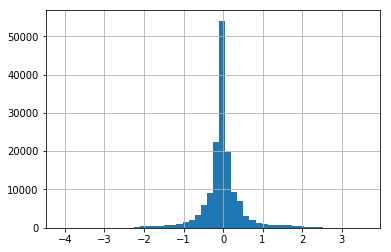

In [434]:
pd.Series(train_rewards).hist(bins=50)

## Get physician actions

In [417]:
def get_phy_actions(df):
    phy_actions = []
    vasos = df['vaso_input'].values
    ivs = df['iv_input'].values
    for i, iv in enumerate(ivs):
        phy_actions += [ action_map[ (iv, vasos[i]) ] ]
    return phy_actions

In [456]:
train_phy_actions = get_phy_actions(train_set)
test_phy_actions = get_phy_actions(test_set)

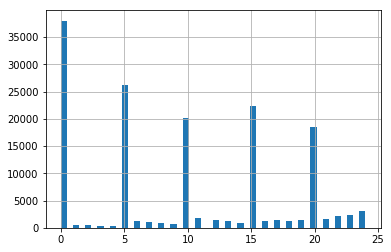

In [419]:
pd.Series(train_phy_actions).hist(bins=50)

## Kernel based expert

In [337]:
kernel_based = pkl.load(open('test_kernel_policy_transformed.pkl', 'rb'), encoding='latin1')

In [350]:
expert_k = kernel_based[:,3]
dist = kernel_based[:,4]

In [447]:
test_input['dist'] = dist

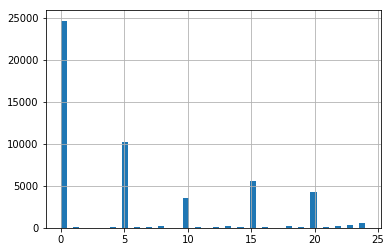

In [370]:
% matplotlib inline
pd.Series(expert_k).hist(bins=50)

## DQN based expert

In [379]:
expert_d = pkl.load(open('../../../code/results/with_end_state/test_agent_actions.pkl', 'rb'), encoding='latin1')

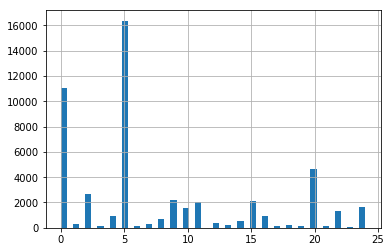

In [380]:
% matplotlib inline
pd.Series(expert_d).hist(bins=50)

## One-hot encode expert actions

In [427]:
def one_hot_action(action_seq):
    encoded_expert = np.zeros((action_seq.shape[0], 25))
    for i, a in enumerate(action_seq):
        encoded_expert[i, int(a)] = 1
    return encoded_expert

In [428]:
encoded_expert_k, encoded_expert_d = one_hot_action(expert_k), one_hot_action(expert_d)

## Learn train set T, R

In [415]:
train_bloc = train_input['num_bloc'].values

In [422]:
trasition = np.zeros((750, 25, 750))
for i, s in enumerate(train_state_list):
    if i == train_state_list.shape[0] - 1:
        break
    if train_bloc[i + 1] == 1:
        continue
    else:
        trasition[s, train_phy_actions[i], train_state_list[i + 1]] += 1

for s in range(750):
    trasition[s] /= np.sum(trasition[s], axis=1, keepdims=True)
trasition = np.nan_to_num(trasition)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [436]:
reward_table = np.zeros((750, 25, 750))
count = np.zeros((750, 25, 750))
for i, s in enumerate(train_state_list):
    if i == train_state_list.shape[0] - 1:
        break
    if train_bloc[i + 1] == 1:
        continue
    else:
        reward_table[s, train_phy_actions[i], train_state_list[i + 1]] += train_rewards[i]
        count[s, train_phy_actions[i], train_state_list[i + 1]] += 1
reward_table = np.nan_to_num(reward_table / count)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


## Experiment building MDP for MOE

In [186]:
t_table = np.zeros((750, 25))

In [187]:
for i, state in enumerate(train_state_list):
    t_table[state, expert1[i]] += probs[i]
    t_table[state, expert2[i]] += (1 - probs[i])

In [189]:
t_table = t_table / np.sum(t_table, axis=1, keepdims=True)

## MDP, WDR, and IS

In [396]:
def policy_eval(MDP, prob_e, gamma=.99):
	# solve by value iteration
	(transition_matrix, reward_table) = MDP
	# print MDP
	V = np.zeros((transition_matrix.shape[0]))
	# compute V table
	while 1:
		delta = 0.
		for s in range(transition_matrix.shape[0]):
			v = np.sum(prob_e[s] * np.sum(transition_matrix[s] * (reward_table[s] + gamma * V), axis = 1))
			delta = max(delta, abs(v - V[s]))
			V[s] = v

		if delta < 0.0001:
			break
			
	# build Q_table
	Q = np.zeros((transition_matrix.shape[0], transition_matrix.shape[1]))
	for s in range(transition_matrix.shape[0]):
		Q[s] = np.sum(transition_matrix[s] * (reward_table[s] + gamma * V), axis = 1)
	return V, Q

In [486]:
# physician pi_b
def get_pi_b(state_list, phy_actions):
    pi_b = np.zeros((750, 25))
    for i, s in enumerate(state_list):
        if i == state_list.shape[0] - 1:
            break
        pi_b[s, phy_actions[i]] += 1
    pi_b = pi_b / np.sum(pi_b, axis=1, keepdims=True)
    return pi_b

In [487]:
train_pi_b = get_pi_b(train_state_list, train_phy_actions)
test_pi_b = np.nan_to_num(get_pi_b(test_state_list, test_phy_actions))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [222]:
def WDR(
    states_sequence, actions_sequence, rewards_sequence, fence_posts, gamma,
    pi_evaluation, pi_behavior, V = None, Q = None, num_of_states = None, num_of_actions = None ):

    num_of_trials = len( fence_posts )
    individual_trial_estimators = []
    pi_evaluation = turn_policy_to_stochastic_policy( \
        pi_evaluation, num_of_states = num_of_states, num_of_actions = num_of_actions )
    pi_behavior = turn_policy_to_stochastic_policy( \
        pi_behavior, num_of_states = num_of_states, num_of_actions = num_of_actions )
    # estimate V and Q if they are not passed as parameters
    if V is None or Q is None:
        # TODO : add part which calculate R and T from data if they are not given
        V, Q = policy_evaluation( T , R , pi_evaluation , gamma )
    # calculate the doubly robust estimator of the policy
    fence_posts_with_length_appended = fence_posts + [ len( states_sequence ) ]
    single_patient_sequences_length = [ fence_posts_with_length_appended[i+1] - \
        fence_posts_with_length_appended[i] for i in range(len(fence_posts)) ]
    length_of_longest_patient_sequence = max( single_patient_sequences_length )
    rho_array = np.nan * np.zeros( ( num_of_trials, length_of_longest_patient_sequence ) )
#    rho_array = np.ones( ( num_of_trials, length_of_longest_patient_sequence ) )
    for trial_i in range( num_of_trials ):
        rho = 1
        if trial_i < num_of_trials - 1:
            steps_in_trial = fence_posts[ trial_i+1 ] -  fence_posts[ trial_i ]
        else:
            steps_in_trial = len( states_sequence) - fence_posts[-1]
        t_within_trial = 0
        for t in range(
                fence_posts[ trial_i], fence_posts[ trial_i] + steps_in_trial ):
            if(pi_behavior[ states_sequence[ t], actions_sequence[ t]]==0):
                print(states_sequence[ t], actions_sequence[ t])
            rho *= pi_evaluation[ states_sequence[ t], actions_sequence[ t]] / \
                pi_behavior[ states_sequence[ t], actions_sequence[ t]]
            rho_array[ trial_i, t_within_trial ] = rho
            t_within_trial += 1
        rho_array[ trial_i, t_within_trial: ] = rho
    weights_normalization = np.sum( rho_array, axis = 0 )
    for trial_i in range( num_of_trials ):
        current_trial_estimator = 0
        rho = 1
        w = 1 / num_of_trials
        discount = 1/gamma
        if trial_i < num_of_trials - 1:
            steps_in_trial = fence_posts[ trial_i+1 ] -  fence_posts[ trial_i ]
        else:
            steps_in_trial = len( states_sequence) - fence_posts[-1]
        t_within_trial = 0
        for t in range(
                fence_posts[ trial_i], fence_posts[ trial_i] + steps_in_trial ):
            previous_w = w
            rho *= pi_evaluation[ states_sequence[ t], actions_sequence[ t]] / \
                pi_behavior[ states_sequence[ t], actions_sequence[ t]]
            w = rho / weights_normalization[ t_within_trial ]
            discount *= gamma
            current_trial_estimator += w * discount * rewards_sequence[ t ] - \
                discount * ( w * Q[ states_sequence[ t ], actions_sequence[ t ] ] - \
                             previous_w * V[ states_sequence[ t ] ] )
            t_within_trial += 1
        individual_trial_estimators += [ current_trial_estimator ]
    estimator = np.sum( individual_trial_estimators )

    return estimator

In [544]:
def IS(
    states_sequence, actions_sequence, rewards_sequence, fence_posts, gamma,
    pi_evaluation, pi_behavior, num_of_states = None, num_of_actions = None ):

    num_of_trials = len( fence_posts )
    individual_trial_estimators = 0
    pi_evaluation = turn_policy_to_stochastic_policy( \
        pi_evaluation, num_of_states = num_of_states, num_of_actions = num_of_actions )
    pi_behavior = turn_policy_to_stochastic_policy( \
        pi_behavior, num_of_states = num_of_states, num_of_actions = num_of_actions )
    for trial_i in range( num_of_trials ):
        rho = 1
        discount = 1/gamma
        trial_return = 0
        if trial_i < num_of_trials - 1:
            steps_in_trial = fence_posts[ trial_i+1 ] -  fence_posts[ trial_i ]
        else:
            steps_in_trial = len( states_sequence) - fence_posts[-1]
        for t in range(
                fence_posts[ trial_i], fence_posts[ trial_i] + steps_in_trial ):
            rho *= pi_evaluation[ t, actions_sequence[ t]] / \
                pi_behavior[ states_sequence[ t], actions_sequence[ t]]
            discount *= gamma
            trial_return += discount * rewards_sequence[ t ]
        individual_trial_estimators += trial_return * rho 
   
    return individual_trial_estimators/ ( num_of_trials )

In [545]:
fence_posts = []
test_bloc = test_input['num_bloc'].values
for i, idx in enumerate(test_bloc):
    if idx == 1:
        fence_posts += [ i ]

In [657]:
def get_expert_actions(w):
    probs = get_experts_action_probs(w, test_input.values)
    moe_actions = []
    for prob in probs:
        if prob >= 0.5:
            moe_actions += [0]
        else:
            moe_actions += [1]
    return moe_actions

## Classifer Training -- autograd

In [546]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def get_experts_action_probs(w, f):
    p = sigmoid(np.sum(f * w, axis=1, keepdims=True))
    return p

In [579]:
def objective(w):
    
    probs = get_experts_action_probs(w, test_input.values)
    pi_e = probs * encoded_expert_k + (1 - probs) * encoded_expert_d
    
    return IS(test_state_list, test_phy_actions, test_rewards, fence_posts, 0.99, pi_e, test_pi_b)

In [659]:
np.random.seed(7)
lr = 0.001
epsilon = 10**-8
w = np.random.normal(scale=0.3, size=(1, 4))
grad_obj = grad(objective)

objs = []
for i in range(200):
    gradient = grad_obj(w)
#     G = np.sum(np.square(gradient))
#     w += ( (lr / np.sqrt( G + epsilon )) * gradient)
    w += lr * gradient
    objs += [ objective(w) ]
    print ('step: ', i, ' objective: ', objs[-1])
    actions = get_expert_actions(w)
    print (w)
    print ( pd.Series(actions).value_counts() )

step:  0  objective:  4.27467596021
[[ 0.51253425 -0.15803333  0.01516204  0.15548581]]
0    50856
1        3
dtype: int64
step:  1  objective:  5.89392753126
[[ 0.51982647 -0.17621445  0.02032257  0.18997916]]
0    50856
1        3
dtype: int64
step:  2  objective:  7.5730265495
[[ 0.52873892 -0.19409859  0.02528528  0.22529135]]
0    50856
1        3
dtype: int64
step:  3  objective:  9.26576706944
[[ 0.53889793 -0.21147812  0.03001216  0.26091286]]
0    50855
1        4
dtype: int64
step:  4  objective:  10.9249781097
[[ 0.54989768 -0.22818485  0.03447406  0.29632598]]
0    50855
1        4
dtype: int64
step:  5  objective:  12.5098709133
[[ 0.56134853 -0.24410239  0.03865351  0.3310618 ]]
0    50855
1        4
dtype: int64
step:  6  objective:  13.9907733304
[[ 0.57291419 -0.25916787  0.04254505  0.36474131]]
0    50855
1        4
dtype: int64
step:  7  objective:  15.3504236891
[[ 0.5843311  -0.27336497  0.0461537   0.39709335]]
0    50855
1        4
dtype: int64
step:  8  objecti

KeyboardInterrupt: 

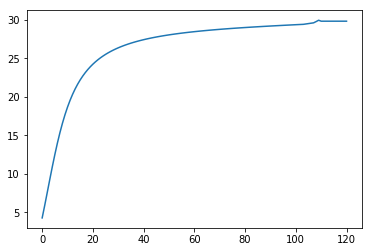

In [607]:
import matplotlib.pyplot as plt
plt.plot(range(len(objs)), objs)

In [610]:
probs = get_experts_action_probs(w, test_input.values)

In [614]:
moe_actions = []
for prob in probs:
    if prob >= 0.5:
        moe_actions += [0]
    else:
        moe_actions += [1]

In [619]:
pd.Series(moe_actions).value_counts()

0    50853
1        6
dtype: int64

In [622]:
w

array([[ 3.33510531, -1.79983661,  0.03756903,  2.78833551]])

In [638]:
test_input.values[2]

array([ 3.        ,  0.        ,  0.005     ,  2.56538748])

In [632]:
probs

array([[ 0.99998933],
       [ 1.        ],
       [ 0.99999996],
       ..., 
       [ 1.        ],
       [ 1.        ],
       [ 1.        ]])

In [656]:
sigmoid(np.sum(test_input.values[3] * np.random.normal(scale=0.3, size=(1, 4)))), test_input.values[2]

(0.45559895843429693,
 array([ 3.        ,  0.        ,  0.005     ,  2.56538748]))

In [ ]:
sigmoid(np.sum(f * w, axis=1, keepdims=True))